In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data

In [2]:
# Using Yiting Cleaned Reviews

full_df = pd.read_csv(filepath_or_buffer='../../data/curated/reviews/cleaned_reviews.csv')
full_df.head()

,Sentiment,Time,Text,processed_text
0,1,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,1,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,1,18/6/21,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,1,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,1,1/7/21,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...


In [12]:
full_df['Sentiment'].value_counts()

1    4030
0    1414
Name: Sentiment, dtype: int64

## Train-Test Split -> leave out 20% for testing

In [13]:
from sklearn.model_selection import train_test_split
full_label = full_df['Sentiment']
full_text = full_df['processed_text']

X_train, X_test, y_train, y_test = train_test_split(full_text, full_label, test_size = 0.2, random_state=4211)

### Feature Engineering with TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(
    max_df = 0.5,
    sublinear_tf = True
)
train_vectors = tf_idf_vectorizer.fit_transform(X_train)

### Fit SVM & Cross Validation

In [15]:
# Fit SVM
import time
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score

In [16]:
svm_linear_classifier = svm.LinearSVC()
k_folds = KFold(n_splits=5)
val_scores = cross_val_score(svm_linear_classifier, train_vectors, y_train, cv=k_folds)

print(f"Cross validation scores: {val_scores}") # [0.90355913 0.88289323 0.86796785 0.88518944 0.88978186]
print(f"Average CV scores: {val_scores.mean()}")

Cross validation scores: [0.90700344 0.88289323 0.86681975 0.88633754 0.89437428]
Average CV scores: 0.8874856486796785


In [17]:
starttrain = time.time()
svm_linear_classifier.fit(train_vectors, y_train)
endtrain = time.time()

### Evaludation and Prediction

In [18]:
test_vectors = tf_idf_vectorizer.transform(X_test)
startpred = time.time()
svm_preds_linear = svm_linear_classifier.predict(test_vectors)
endpred = time.time()

print(f"Training time: {endtrain - starttrain}")
print(f"Prediction time: {endpred - startpred}")


Training time: 0.0438389778137207
Prediction time: 0.0010027885437011719


### Results

In [20]:
print("Training time: %fs; Prediction time: %fs" % (endtrain - starttrain, endpred - startpred))
report = classification_report(y_test, svm_preds_linear, output_dict=True)
print('negative: ', report['0'])
print('positive: ', report['1'])
print('accuracy: ', report['accuracy'])

Training time: 0.043839s; Prediction time: 0.001003s
negative:  {'precision': 0.8181818181818182, 'recall': 0.7226277372262774, 'f1-score': 0.7674418604651163, 'support': 274}
positive:  {'precision': 0.910271546635183, 'recall': 0.9460122699386503, 'f1-score': 0.927797833935018, 'support': 815}
accuracy:  0.8898071625344353


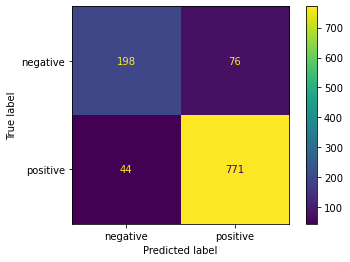

In [22]:
cm = confusion_matrix(y_test, svm_preds_linear)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
cm_display.plot()

In [23]:
# pickling the IF-IDF Vectorizer
import pickle
pickle.dump(tf_idf_vectorizer, open('../../model/svm_vectorizer.pkl', 'wb'))

# pickling the SVM Linear Classifier
pickle.dump(svm_linear_classifier, open('../../model/svm.pkl', 'wb'))

### Inference on full dataset

In [24]:
full_text_vectors = tf_idf_vectorizer.transform(full_text)
svm_full_preds_linear = svm_linear_classifier.predict(full_text_vectors)

report_full = classification_report(full_label, svm_full_preds_linear, output_dict=True)
print('negative: ', report_full['0'])
print('positive: ', report_full['1'])
print('accuracy: ', report_full['accuracy'])

negative:  {'precision': 0.9663003663003663, 'recall': 0.9328147100424328, 'f1-score': 0.9492623245771861, 'support': 1414}
positive:  {'precision': 0.9767099779357685, 'recall': 0.9885856079404467, 'f1-score': 0.982611912689604, 'support': 4030}
accuracy:  0.9740999265246143
